In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import torch
import gc

# Clear all cached memory
torch.cuda.empty_cache()
gc.collect()

# Check memory usage
print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
print(f"GPU memory cached: {torch.cuda.memory_reserved()/1024**3:.2f} GB")

GPU memory allocated: 0.00 GB
GPU memory cached: 0.00 GB


In [3]:
import pickle

with open('resized_combined_dataset.pkl', 'rb') as f:
    datasets = pickle.load(f)

In [4]:
with open('resized_combined_dataset_new.pkl', 'rb') as f:
    datasets_new = pickle.load(f)

In [9]:
from sklearn.model_selection import train_test_split

# Split datasets_new into training and testing portions (e.g., 80% train, 20% test)
images_new = [img for img, label in datasets_new]
labels_new = [label for img, label in datasets_new]

X_new_train_val, X_new_test, y_new_train_val, y_new_test = train_test_split(
    images_new, labels_new, test_size=0.2, random_state=42, stratify=labels_new
)

print(f"Training samples: {len(X_new_train_val)}, Testing samples: {len(X_new_test)}")

Training samples: 140, Testing samples: 36


In [5]:
# Combine datasets and datasets_new
combined_datasets = datasets + datasets_new
print(f"Total samples after combining: {len(combined_datasets)}")

Total samples after combining: 2568


In [7]:
X = [img for img, label in datasets]
y = [label for img, label in datasets]

In [8]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Image transformation with augmentation
augmented_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# Custom dataset for PIL images and labels
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_new_train, X_new_val, y_new_train, y_new_val = train_test_split(
    X_new_train_val, y_new_train_val, test_size=0.2, random_state=42, stratify=y_new_train_val
)

X_train_combined = X_train + X_new_train
y_train_combined = y_train + y_new_train

X_val_combined = X_val + X_new_val
y_val_combined = y_val + y_new_val

# Create datasets and dataloaders for train and validation
train_dataset = ImageDataset(X_train_combined, y_train_combined, transform=augmented_transform)
val_dataset = ImageDataset(X_val_combined, y_val_combined, transform=augmented_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [11]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training loop
num_epochs = 60
train_losses= []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader: 
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_acc = correct / len(val_loader.dataset)

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

Epoch 1/60 - Train Loss: 0.7064 - Val Loss: 0.6524 - Val Acc: 0.6134
Epoch 11/60 - Train Loss: 0.2800 - Val Loss: 0.2422 - Val Acc: 0.8935
Epoch 21/60 - Train Loss: 0.1988 - Val Loss: 0.2114 - Val Acc: 0.9310
Epoch 31/60 - Train Loss: 0.1274 - Val Loss: 0.1466 - Val Acc: 0.9527
Epoch 41/60 - Train Loss: 0.0748 - Val Loss: 0.1158 - Val Acc: 0.9586
Epoch 51/60 - Train Loss: 0.0733 - Val Loss: 0.0870 - Val Acc: 0.9645


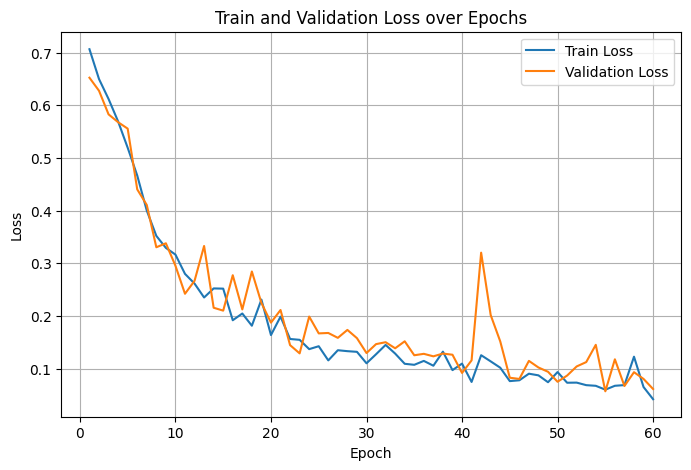

In [14]:
import matplotlib.pyplot as plt


# If you already have train_losses and val_losses lists, plot them:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       261
           1       0.98      0.97      0.98       246

    accuracy                           0.98       507
   macro avg       0.98      0.98      0.98       507
weighted avg       0.98      0.98      0.98       507



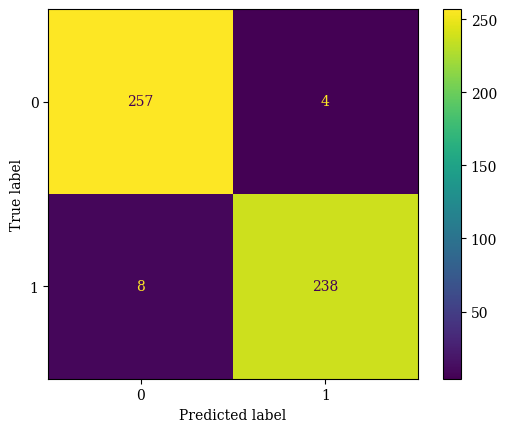

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'serif'

# Get predictions for the entire validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

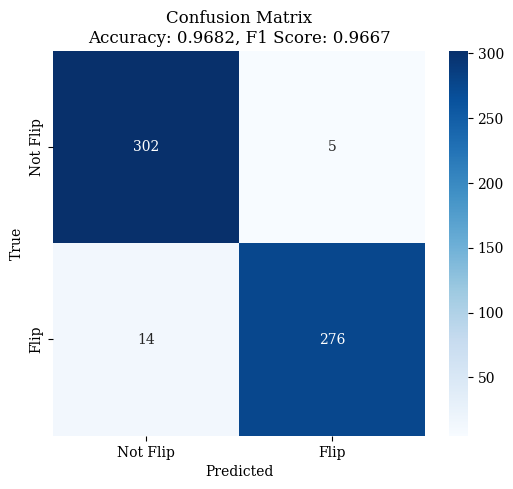

In [16]:
import os
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from random import shuffle

# Load test images and labels
test_flip_dir = os.path.join('images', 'testing', 'flip')
test_notflip_dir = os.path.join('images', 'testing', 'notflip')

test_flip_images = []
for filename in os.listdir(test_flip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(test_flip_dir, filename)
        img = Image.open(img_path)
        test_flip_images.append(img)

test_notflip_images = []
for filename in os.listdir(test_notflip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(test_notflip_dir, filename)
        img = Image.open(img_path)
        test_notflip_images.append(img)

# Create labeled test dataset
test_flip_dataset = [(img, 1) for img in test_flip_images]
test_notflip_dataset = [(img, 0) for img in test_notflip_images]
test_combined_dataset = test_flip_dataset + test_notflip_dataset
shuffle(test_combined_dataset)

X_test = [img for img, label in test_combined_dataset]
y_test = [label for img, label in test_combined_dataset]

# Create test dataset and dataloader
test_dataset = ImageDataset(X_test, y_test, transform=augmented_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Predict labels using trained model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy and F1 score
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.rcParams["font.family"] = "serif"
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flip', 'Flip'], yticklabels=['Not Flip', 'Flip'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix\nAccuracy: {acc:.4f}, F1 Score: {f1:.4f}')
plt.show()

In [17]:
# Visualize feature maps at the end of each CNN layer for a sample image

def visualize_feature_maps(model, image, device, suptitle):
    model.eval()
    image = augmented_transform(image).unsqueeze(0).to(device)

    # Forward pass and capture outputs after each conv layer
    with torch.no_grad():
        x = F.relu(model.conv1(image))
        x1 = model.pool(x)
        x2 = F.relu(model.conv2(x1))
        x2 = model.pool(x2)

    # Helper to plot feature maps
    def plot_feature_maps(feature_tensor, title, num_channels=8):
        plt.figure(figsize=(15, 2))
        for i in range(num_channels):
            plt.subplot(1, num_channels, i+1)
            plt.imshow(feature_tensor[0, i].cpu(), cmap='rainbow')
            plt.axis('off')
            plt.title(f'{title} {i+1}')
        plt.suptitle(suptitle)
        plt.tight_layout()
        plt.show()

    plot_feature_maps(x1, 'Conv1 Features')
    plot_feature_maps(x2, 'Conv2 Features')

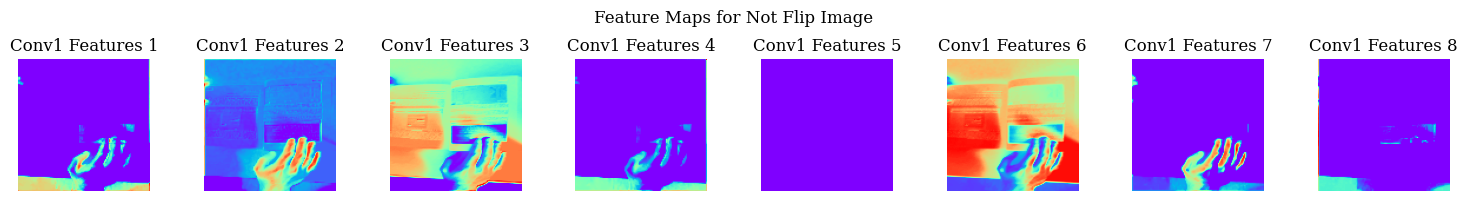

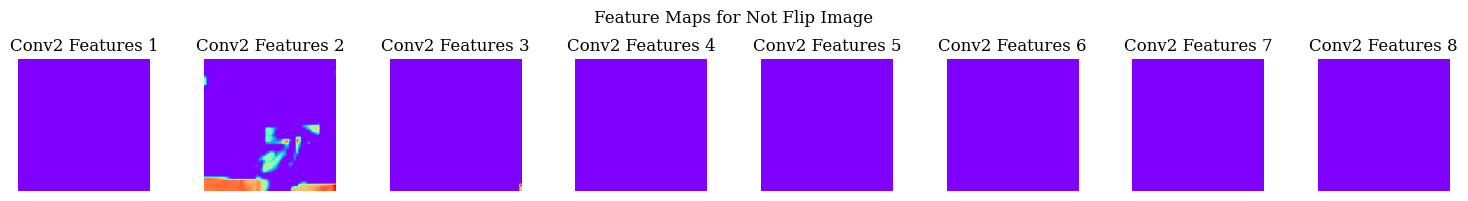

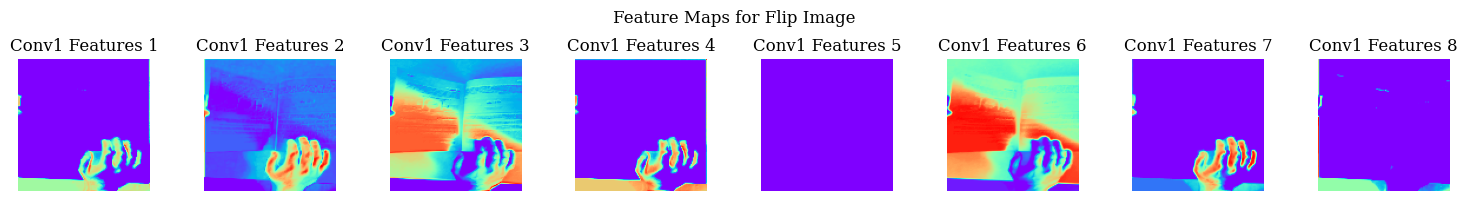

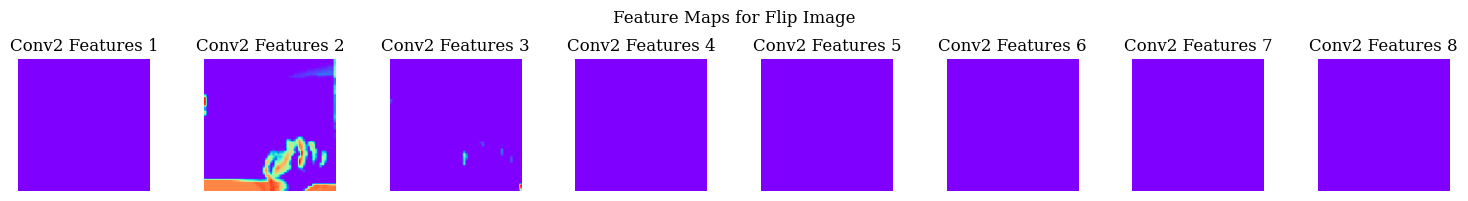

In [18]:
# Example: visualize features for a notflip image
visualize_feature_maps(model, test_notflip_images[8], device, 'Feature Maps for Not Flip Image')

# Example: visualize features for a flip image
visualize_feature_maps(model, test_flip_images[10], device, 'Feature Maps for Flip Image')

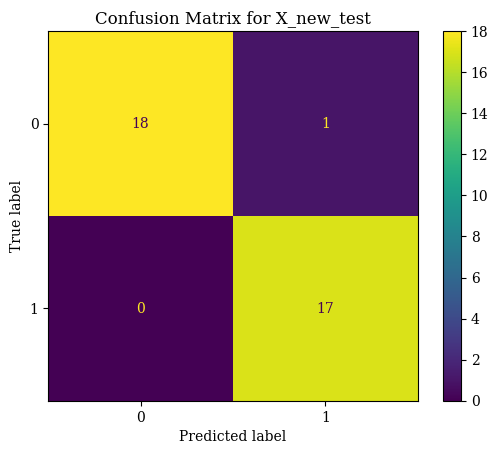

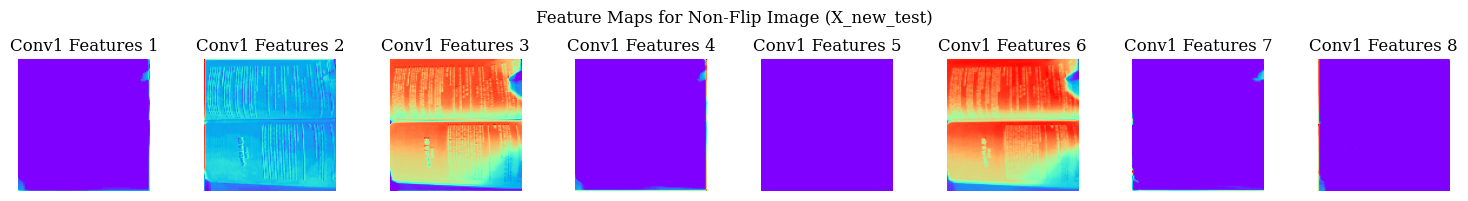

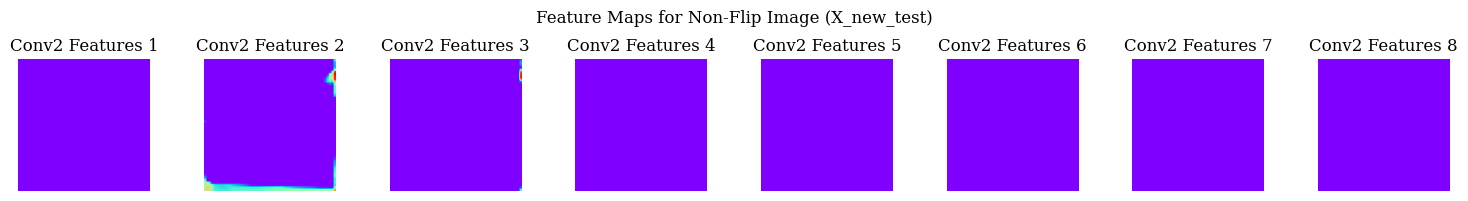

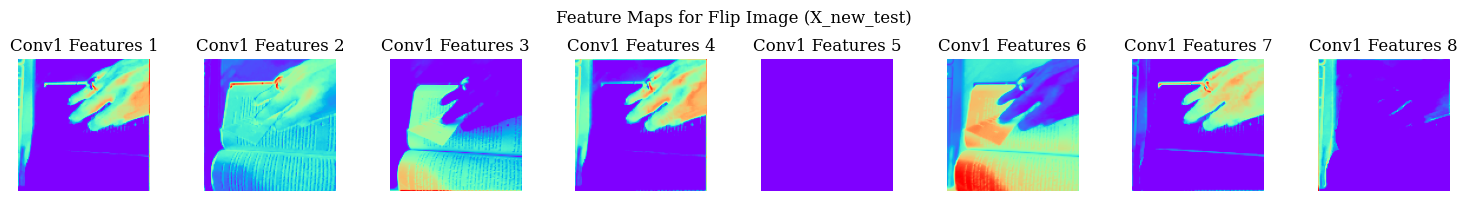

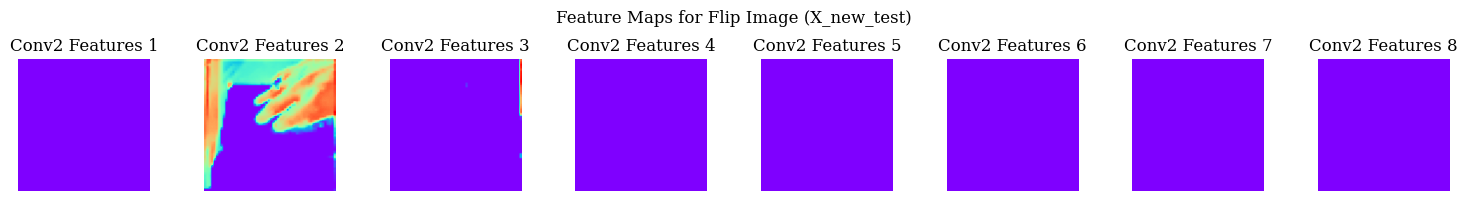

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prepare test dataset and dataloader using X_new_test and y_new_test
test_new_dataset = ImageDataset(X_new_test, y_new_test, transform=augmented_transform)
test_new_loader = DataLoader(test_new_dataset, batch_size=32, shuffle=False)

# Model evaluation on new test set
model.eval()
all_preds_new = []
all_labels_new = []
with torch.no_grad():
    for images, labels in test_new_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds_new.extend(preds.cpu().numpy())
        all_labels_new.extend(labels.cpu().numpy())

# Show confusion matrix
cm_new = confusion_matrix(all_labels_new, all_preds_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new)
disp_new.plot()
plt.title("Confusion Matrix for X_new_test")
plt.show()

# Feature visualizations for a flip and non-flip sample from X_new_test
# Find indices for flip (label==1) and non-flip (label==0)
flip_idx = next(i for i, lbl in enumerate(y_new_test) if lbl == 1)
nonflip_idx = next(i for i, lbl in enumerate(y_new_test) if lbl == 0)

visualize_feature_maps(model, X_new_test[nonflip_idx], device, 'Feature Maps for Non-Flip Image (X_new_test)')
visualize_feature_maps(model, X_new_test[flip_idx], device, 'Feature Maps for Flip Image (X_new_test)')